In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np

In [2]:
directory_list = [ d for d in os.listdir( 'dataset' ) ]
directory_list

['center',
 'near_left',
 'near_right',
 'off_left',
 'off_right',
 'tunnel_left',
 'tunnel_right',
 'wall_left',
 'wall_right']

In [3]:
file_list = list( )
for d in directory_list:
    files      = [ 'dataset/{}/{}'.format( d , f ) for f in os.listdir( 'dataset/{}'.format( d ) ) ]
    file_list += files
file_list[:10]

['dataset/center/frame0.jpg',
 'dataset/center/frame1.jpg',
 'dataset/center/frame10.jpg',
 'dataset/center/frame100.jpg',
 'dataset/center/frame1000.jpg',
 'dataset/center/frame1001.jpg',
 'dataset/center/frame1002.jpg',
 'dataset/center/frame1003.jpg',
 'dataset/center/frame1004.jpg',
 'dataset/center/frame1005.jpg']

In [4]:
H,W = np.shape( Image.open( file_list[0] ).convert( 'L' ) )

resize_scale = 10
H2 , W2 = H//resize_scale , W//resize_scale

print( 'Original Shape = %d x %d => %d Pixels' % ( H , W , H*W ) )
print( 'Resized Shape = %d x %d => %d Pixels' % ( H2 , W2 , H2*W2 ) )

Original Shape = 640 x 802 => 513280 Pixels
Resized Shape = 64 x 80 => 5120 Pixels


In [5]:
classes = {
    0:'center',
    1:'near_left',
    2:'near_right',
    3:'off_left',
    4:'off_right',
    5:'wall_left',
    6:'wall_right',
    7:'tunnel_left',
    8:'tunnel_right',
    'center':0,
    'near_left':1,
    'near_right':2,
    'off_left':3,
    'off_right':4,
    'wall_left':5,
    'wall_right':6,
    'tunnel_left':7,
    'tunnel_right':8
}
n_images = len( file_list )
arr = np.zeros( ( n_images , H2 , W2 ) )
labels = list()
print('Loading Images...')
for i in range( n_images ):
    im = Image.open( file_list[i] ).convert( 'L' ).resize( ( W2 , H2 ) )
    arr[i,:] = np.asarray( im )
    labels.append(classes[file_list[i].split('/')[1]])
    if (i+1) % (n_images//100) == 0:
        print('Image {}/{} Loaded...'.format(i+1,n_images))
labels = np.array( labels )
print('Done')

Loading Images...
Image 356/35657 Loaded...
Image 712/35657 Loaded...
Image 1068/35657 Loaded...
Image 1424/35657 Loaded...
Image 1780/35657 Loaded...
Image 2136/35657 Loaded...
Image 2492/35657 Loaded...
Image 2848/35657 Loaded...
Image 3204/35657 Loaded...
Image 3560/35657 Loaded...
Image 3916/35657 Loaded...
Image 4272/35657 Loaded...
Image 4628/35657 Loaded...
Image 4984/35657 Loaded...
Image 5340/35657 Loaded...
Image 5696/35657 Loaded...
Image 6052/35657 Loaded...
Image 6408/35657 Loaded...
Image 6764/35657 Loaded...
Image 7120/35657 Loaded...
Image 7476/35657 Loaded...
Image 7832/35657 Loaded...
Image 8188/35657 Loaded...
Image 8544/35657 Loaded...
Image 8900/35657 Loaded...
Image 9256/35657 Loaded...
Image 9612/35657 Loaded...
Image 9968/35657 Loaded...
Image 10324/35657 Loaded...
Image 10680/35657 Loaded...
Image 11036/35657 Loaded...
Image 11392/35657 Loaded...
Image 11748/35657 Loaded...
Image 12104/35657 Loaded...
Image 12460/35657 Loaded...
Image 12816/35657 Loaded...
Imag

In [6]:
'''
import os
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np

classes = {
    0:'center',
    1:'near_left',
    2:'near_right',
    3:'off_left',
    4:'off_right',
    5:'wall_left',
    6:'wall_right'
}
data = np.array([])
labels = np.array([])
old_size = Image.open('dataset/center/frame0.jpg').size
resize_factor = 10
counter = 0
new_size = (old_size[0]//resize_factor, old_size[1]//resize_factor)
for filename in os.listdir('dataset/center'):
    if filename.endswith('.jpg'):
        print('dataset/center/{}'.format(filename))
        im = Image.open('dataset/center/{}'.format(filename)).convert('L').resize(new_size)
        pixels = np.asarray(im)/255
        data = np.append(data, pixels)
        labels = np.append(labels,[0])
        counter += 1
for filename in os.listdir('dataset/near_left'):
    if filename.endswith('.jpg'):
        print('dataset/near_left/{}'.format(filename))
        im = Image.open('dataset/near_left/{}'.format(filename)).convert('L').resize(new_size)
        pixels = np.asarray(im)/255
        data = np.append(data, pixels)
        labels = np.append(labels,[1])
        counter += 1
for filename in os.listdir('dataset/near_right'):
    if filename.endswith('.jpg'):
        print('dataset/near_right/{}'.format(filename))
        im = Image.open('dataset/near_right/{}'.format(filename)).convert('L').resize(new_size)
        pixels = np.asarray(im)/255
        data = np.append(data, pixels)
        labels = np.append(labels,[2])
        counter += 1
for filename in os.listdir('dataset/off_left'):
    if filename.endswith('.jpg'):
        print('dataset/off_left/{}'.format(filename))
        im = Image.open('dataset/off_left/{}'.format(filename)).convert('L').resize(new_size)
        pixels = np.asarray(im)/255
        data = np.append(data, pixels)
        labels = np.append(labels,[3])
        counter += 1
for filename in os.listdir('dataset/off_right'):
    if filename.endswith('.jpg'):
        print('dataset/off_right/{}'.format(filename))
        im = Image.open('dataset/off_right/{}'.format(filename)).convert('L').resize(new_size)
        pixels = np.asarray(im)/255
        data = np.append(data, pixels)
        labels = np.append(labels,[4])
        counter += 1
for filename in os.listdir('dataset/wall_left'):
    if filename.endswith('.jpg'):
        print('dataset/wall_left/{}'.format(filename))
        im = Image.open('dataset/wall_left/{}'.format(filename)).convert('L').resize(new_size)
        pixels = np.asarray(im)/255
        data = np.append(data, pixels)
        labels = np.append(labels,[5])
        counter += 1
for filename in os.listdir('dataset/wall_right'):
    if filename.endswith('.jpg'):
        print('dataset/wall_right/{}'.format(filename))
        im = Image.open('dataset/wall_right/{}'.format(filename)).convert('L').resize(new_size)
        pixels = np.asarray(im)/255
        data = np.append(data, pixels)
        labels = np.append(labels,[6])
        counter += 1

data = data.reshape((counter,pixels.shape[0], pixels.shape[1]))
#plt.figure()
#plt.imshow(data.mean(axis=0),cmap='gray')
#plt.show()
'''

"\nimport os\nimport matplotlib.pyplot as plt\nfrom PIL import Image\nimport pandas as pd\nimport numpy as np\n\nclasses = {\n    0:'center',\n    1:'near_left',\n    2:'near_right',\n    3:'off_left',\n    4:'off_right',\n    5:'wall_left',\n    6:'wall_right'\n}\ndata = np.array([])\nlabels = np.array([])\nold_size = Image.open('dataset/center/frame0.jpg').size\nresize_factor = 10\ncounter = 0\nnew_size = (old_size[0]//resize_factor, old_size[1]//resize_factor)\nfor filename in os.listdir('dataset/center'):\n    if filename.endswith('.jpg'):\n        print('dataset/center/{}'.format(filename))\n        im = Image.open('dataset/center/{}'.format(filename)).convert('L').resize(new_size)\n        pixels = np.asarray(im)/255\n        data = np.append(data, pixels)\n        labels = np.append(labels,[0])\n        counter += 1\nfor filename in os.listdir('dataset/near_left'):\n    if filename.endswith('.jpg'):\n        print('dataset/near_left/{}'.format(filename))\n        im = Image.open

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(arr,labels)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test  = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

In [14]:
import tensorflow as tf
from tensorflow import keras

gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

conv_input_size  = ( arr[0].shape[0] , arr[0].shape[1] , 1 )
conv_input_layer = keras.Input( conv_input_size , name="conv_input" )   # create input layer
print( conv_input_layer )

Tensor("conv_input_1:0", shape=(None, 64, 80, 1), dtype=float32)


In [15]:
# === 3x3 Convolution Layer/Filter === #
# Output shape = 32 (not sure why, was given)
# Kernel size  = 3x3 (3x3 filter)
# Activation   = relu (ReLu activation function)
conv_layer_1 = keras.layers.Conv2D( 32, 
                                    kernel_size=( 3 , 3 ), 
                                    activation="relu",
                                    name="conv_layer_1" )

# === Maxpool Layer to Reduce Dimensionality === #
# Pool Size = 2x2 
maxpool_1 = keras.layers.MaxPooling2D( pool_size=( 2 , 2 ),
                                       name="maxpool_1" )

# === 3x3 Convolutional Layer/Filter === #
# Output Shape = 64 (not sure why, was given)
# Kernel size  = 3x3 (3x3 filter)
# Activation   = relu (ReLu activation function)
conv_layer_2 = keras.layers.Conv2D( 64, 
                                    kernel_size=( 3 , 3 ), 
                                    activation="relu",
                                    name="conv_layer_2" )

# === Final Maxpool Layer to Reduce Dimensionality Once More === #
# Pool Size = 2x2
maxpool_2 = keras.layers.MaxPooling2D( pool_size=( 2 , 2 ),
                                       name="maxpool_2" )

# === Flatten the Layers (I'm guessing to flatten for the "dense" output layer) === #
flatten = keras.layers.Flatten( )

# === Add a Dense Layer to Map the Above to one of 10 classes === #
conv_class_layer = keras.layers.Dense( 9 , activation="softmax" )

In [16]:
# === List of the Layers Made in the Last Cell === #
conv_layers = [conv_input_layer,
               conv_layer_1,
               maxpool_1,
               conv_layer_2,
               maxpool_2,
               flatten,
               conv_class_layer]

In [17]:
# === Construct and Summarize Keras Model We Defined === #
conv_model = keras.Sequential( layers=conv_layers )
conv_model.summary( )

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer_1 (Conv2D)        (None, 62, 78, 32)        320       
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 31, 39, 32)        0         
_________________________________________________________________
conv_layer_2 (Conv2D)        (None, 29, 37, 64)        18496     
_________________________________________________________________
maxpool_2 (MaxPooling2D)     (None, 14, 18, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16128)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 145161    
Total params: 163,977
Trainable params: 163,977
Non-trainable params: 0
________________________________________________

In [18]:
conv_model.compile( loss="sparse_categorical_crossentropy" , optimizer="adam" , metrics=["accuracy"] )

In [19]:
# === Train the Model to Our Data for 25 Epochs === #
conv_hist = conv_model.fit( X_train,
                            y_train,
                            batch_size=128,
                            epochs=100,
                            validation_data=( X_test , y_test ) )

# === Extract History Values for Later Plotting === #
conv_hist_dict = conv_hist.history

Train on 26742 samples, validate on 8915 samples
Epoch 1/100
26742/26742 [==============================] - 3s 122us/sample - loss: 4.8856 - accuracy: 0.8024 - val_loss: 0.1438 - val_accuracy: 0.9494
Epoch 2/100
26742/26742 [==============================] - 3s 109us/sample - loss: 0.1085 - accuracy: 0.9642 - val_loss: 0.0997 - val_accuracy: 0.9644
Epoch 3/100
26742/26742 [==============================] - 3s 109us/sample - loss: 0.0694 - accuracy: 0.9775 - val_loss: 0.0754 - val_accuracy: 0.9735
Epoch 4/100
26742/26742 [==============================] - 3s 109us/sample - loss: 0.0505 - accuracy: 0.9834 - val_loss: 0.0721 - val_accuracy: 0.9773
Epoch 5/100
26742/26742 [==============================] - 3s 110us/sample - loss: 0.0416 - accuracy: 0.9852 - val_loss: 0.0645 - val_accuracy: 0.9807
Epoch 6/100
26742/26742 [==============================] - 3s 111us/sample - loss: 0.0355 - accuracy: 0.9880 - val_loss: 0.0521 - val_accuracy: 0.9832
Epoch 7/100
26742/26742 [====================

26742/26742 [==============================] - 3s 112us/sample - loss: 0.0016 - accuracy: 0.9996 - val_loss: 0.0138 - val_accuracy: 0.9973
Epoch 55/100
26742/26742 [==============================] - 3s 112us/sample - loss: 0.0016 - accuracy: 0.9996 - val_loss: 0.0140 - val_accuracy: 0.9972
Epoch 56/100
26742/26742 [==============================] - 3s 112us/sample - loss: 0.0016 - accuracy: 0.9996 - val_loss: 0.0140 - val_accuracy: 0.9974
Epoch 57/100
26742/26742 [==============================] - 3s 112us/sample - loss: 0.0017 - accuracy: 0.9996 - val_loss: 0.0137 - val_accuracy: 0.9973
Epoch 58/100
26742/26742 [==============================] - 3s 112us/sample - loss: 0.0017 - accuracy: 0.9996 - val_loss: 0.0138 - val_accuracy: 0.9974
Epoch 59/100
26742/26742 [==============================] - 3s 112us/sample - loss: 0.0016 - accuracy: 0.9996 - val_loss: 0.0138 - val_accuracy: 0.9973
Epoch 60/100
26742/26742 [==============================] - 3s 113us/sample - loss: 0.0016 - accuracy

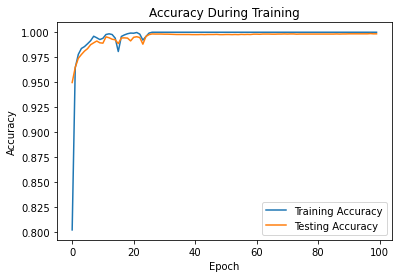

In [20]:
# === Plot the Data === #
plt.plot( conv_hist_dict['accuracy']     , label='Training Accuracy' )
plt.plot( conv_hist_dict['val_accuracy'] , label='Testing Accuracy'  )

# === Label the Chart === #
plt.xlabel( 'Epoch' )
plt.ylabel( 'Accuracy' )
plt.title( 'Accuracy During Training' )
plt.legend( )

# === Display the Chart === #
plt.show( )

In [21]:
tf.keras.models.save_model(
    conv_model,
    'model_v3.h5',
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

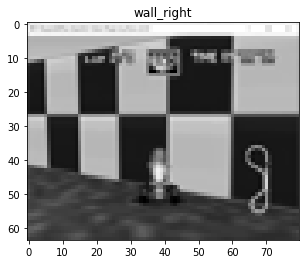

(1, 64, 80, 1)

In [22]:
#conv_model.predict(X_test[0].reshape(X_test[0].shape[0], X_test[0].shape[1], X_test[0].shape[2],1))

test_idx = 420
weights = conv_model.predict(X_test[test_idx].reshape(1,X_test[test_idx].shape[0], X_test[test_idx].shape[1], X_test[0].shape[2]))
classification = classes[np.argmax(weights)]
plt.figure()
plt.imshow(X_test[test_idx].reshape(X_test[test_idx].shape[0], X_test[test_idx].shape[1]),cmap='gray')
plt.title(classification)
plt.show()

X_test[test_idx].reshape(1,X_test[test_idx].shape[0], X_test[test_idx].shape[1], X_test[0].shape[2]).shape

In [23]:
print('Number of Training Items: {}'.format(len(y_train)))
print('Number of Testing Items:  {}'.format(len(y_test)))
print('Full Dataset Contained {} Frames'.format(len(arr)))

Number of Training Items: 26742
Number of Testing Items:  8915
Full Dataset Contained 35657 Frames
